## Recipe Ingredient Analysis Notebook

### Objectives and Approach

In this notebook, I will work on analyzing ingredients from a Spanish recipe dataset with the following goals:

- **Identify whether a given word or phrase is an ingredient or not**, using a combination of rule-based checks and embedding-based similarity.
- **Detect duplicate ingredients** that appear in different forms (e.g., gender variations like *quemado/quemada*, singular/plural forms) to clean and consolidate the ingredient list.
- **Find substitute or similar ingredients** by leveraging word embeddings, helping with recipe modification or alternative recommendations.
- **Create meaningful categories or clusters of ingredients** to organize them better (e.g., spices, vegetables, dairy).

The code will be designed modularly, allowing us to switch between different embedding models or techniques easily.  
Initially, I will use a **custom-trained Word2Vec model** built on our Spanish recipe corpus to capture the semantic relationships between ingredients.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_auc_score, roc_curve, average_precision_score
from sklearn.base import BaseEstimator, TransformerMixin


import gensim

In [3]:
# Load the embedding model (assuming it's a Word2Vec model saved as 'w2v_ngram.model')
embedding_model = gensim.models.Word2Vec.load('models/w2v_ngram.model')

def get_embeddings(words, model=embedding_model):
    """
    Returns a list of embeddings for the given list of words.
    If a word is not in the vocabulary, returns None for that word.
    """
    embeddings = {}
    for word in words:
        # convert any spaces to '_' example 'pimiento rojo' = 'pimiento_rojo'
        word = word.replace(' ','_')
        if word in model.wv:
            embeddings[word] = (model.wv[word])
    
    res = pd.DataFrame.from_dict(embeddings, orient= 'index')
    return res.reindex(words).to_numpy()

get_embeddings(['harina', 'pimentón_dulce', 'ponla'], embedding_model).shape

(3, 300)

### Ingredient Classification: Yes or No?

This section focuses on building a classification model to determine whether a given word or n-gram represents an **ingredient** or **not**.

We will experiment with the following models:

- **Logistic Regression**: A strong baseline for binary classification that performs well with high-dimensional data.
- **Random Forest**: Provides good generalization and handles non-linear relationships, helping with noisy or imperfect labels.

### Why we're not using:
- **Naive Bayes** – cannot handle dense, real-valued embeddings (like Word2Vec or FastText), and violates the independence assumption.
- **K-Nearest Neighbors (KNN)**: Too slow for prediction on large, imbalanced datasets.
- **Support Vector Machines (SVM)**: Not ideal for large datasets and may struggle when classes aren't linearly separable.
- **Decision Trees**: Prone to overfitting, especially with noisy labels.

### Considerations:
- Our training dataset was **manually labeled**, so it's crucial the model is **robust to mislabeled examples** or outliers.
- Evaluation will include manual inspection of edge cases and common mistakes.

### Test Cases:
- `"harina de trigo"` → ingredient  
- `"precalentar el horno"` → not an ingredient  
- `"queso rallado"` → ingredient  
- `"batir los huevos"` → not an ingredient  

In [4]:
data =pd.read_csv("data/is_ingrediente.csv").rename(columns = {'Unnamed: 0':'word'})
data.sample(6)

,word,is_ingrediente
2745,proporcionar,False
1631,mantequilla_derretida,True
6835,sécalas,False
4581,saltea_durante,True
8638,misma_operación,False
1496,el_queso_parmesano,True


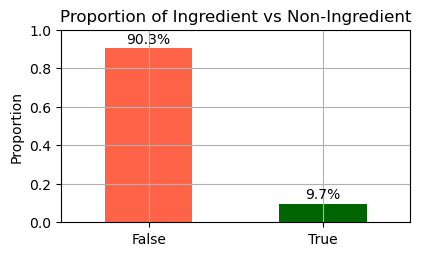

In [5]:
plt.figure(figsize= (4.5,2.5))
data['is_ingrediente'].value_counts(normalize=True).plot(
    kind='bar',
    color=['tomato', 'darkgreen'],
    rot=0
)
plt.title('Proportion of Ingredient vs Non-Ingredient')
plt.xlabel(None)
plt.ylabel('Proportion')
plt.xticks([0, 1], ['False', 'True'])
plt.ylim((0,1))

# Add text labels to each bar
for i, v in enumerate(data['is_ingrediente'].value_counts(normalize=True)):
    plt.text(i, v + 0.01, f"{v:.1%}", ha='center', va='bottom', fontsize= 10)

plt.grid()
plt.show()


In [6]:
class EmbeddingVectorizer(BaseEstimator, TransformerMixin):
    """
    Sklearn-compatible transformer that converts a list of words/phrases
    to their embedding vectors using a gensim Word2Vec model.
    If a word is not in the model, returns a zero vector of the same dimension.
    """
    def __init__(self, model):
        self.model = model
        self.dim = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X is expected to be a list or array of strings
        return get_embeddings(X, self.model)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data['word'], data['is_ingrediente'].astype(int), test_size= 0.3, 
                                                    stratify= data['is_ingrediente'])

In [8]:
logreg_pipe = Pipeline([
    ('embed', EmbeddingVectorizer(embedding_model)),
    ('clf', LogisticRegression())
])
logreg_pipe.fit(X_train, y_train)
print(f"Test Accuracy for Logistic Regression: {100*logreg_pipe.score(X_test, y_test):.1f}%\n")

rf_params = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

rf_pipe = Pipeline([
    ('embed', EmbeddingVectorizer(embedding_model)),
    ('clf', RandomForestClassifier(random_state=42))
])

rf_grid = GridSearchCV(rf_pipe, rf_params, cv=3, n_jobs=-1, verbose=1, scoring= 'recall')
rf_grid.fit(X_train, y_train)

print(f"Best RF Params: {rf_grid.best_params_}")

print(f"Test Accuracy for Random Forest: {100*accuracy_score(y_test, rf_grid.predict(X_test)):.1f}%")

Test Accuracy for Logistic Regression: 91.8%

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF Params: {'clf__max_depth': 20, 'clf__min_samples_split': 5, 'clf__n_estimators': 50}
Test Accuracy for Random Forest: 91.8%


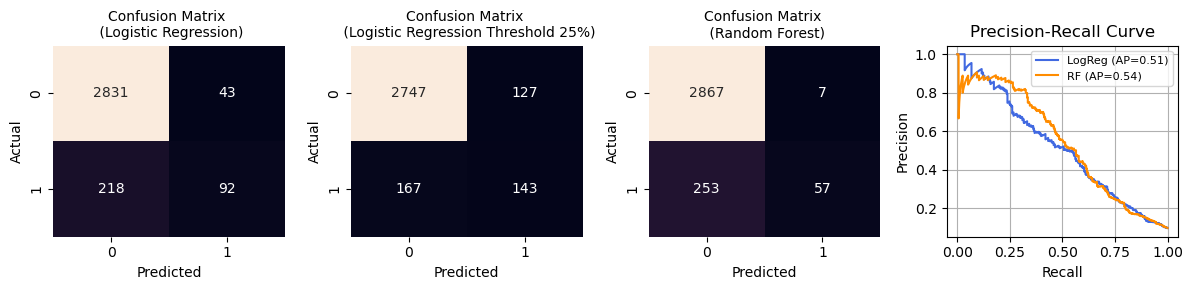

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

# Logistic Regression confusion matrix
logreg_cm = confusion_matrix(y_test, logreg_pipe.predict(X_test))
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='rocket', ax=axes[0], cbar=False)
axes[0].set_title('Confusion Matrix \n (Logistic Regression)', fontsize= 10)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Logistic Regression confusion matrix with threshold 0.25
# Apply threshold of 0.3
y_pred_var = (logreg_pipe.predict_proba(X_test)[:, 1] >= 0.25).astype(int)
logreg_cm_var = confusion_matrix(y_test, y_pred_var)
sns.heatmap(logreg_cm_var, annot=True, fmt='d', cmap='rocket', ax=axes[1], cbar=False)
axes[1].set_title('Confusion Matrix \n (Logistic Regression Threshold 25%)', fontsize= 10)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Random Forest confusion matrix
rf_cm = confusion_matrix(y_test, rf_grid.predict(X_test))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='rocket', ax=axes[2], cbar=False)
axes[2].set_title('Confusion Matrix \n (Random Forest)', fontsize= 10)
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

y_score_logreg = logreg_pipe.predict_proba(X_test)[:, 1]
y_score_rf = rf_grid.predict_proba(X_test)[:,1]
# Logistic Regression PR
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_score_logreg)
ap_logreg = average_precision_score(y_test, y_score_logreg)
axes[3].plot(recall_logreg, precision_logreg, label=f'LogReg (AP={ap_logreg:.2f})', color='royalblue')

# Random Forest PR
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_score_rf)
ap_rf = average_precision_score(y_test, y_score_rf)
axes[3].plot(recall_rf, precision_rf, label=f'RF (AP={ap_rf:.2f})', color='darkorange')

# Plot formatting
axes[3].set_title('Precision-Recall Curve')
axes[3].set_xlabel('Recall')
axes[3].set_ylabel('Precision')
axes[3].legend(loc='upper right', fontsize=8)
axes[3].grid(True)


plt.tight_layout()
plt.show()

### Clustering Ingredients

In this section, we begin clustering ingredient names based on their word embeddings to identify similar or duplicate ingredients (e.g., "harina" and "harinas", "ajo" and "diente de ajo"). This will help group variations and synonyms together for further cleaning and categorization.

We will:
- Use the custom Word2Vec embeddings trained on our recipe corpus
- Apply dimensionality reduction (e.g., PCA or t-SNE) for visualization
- Use clustering algorithms like KMeans or DBSCAN to group similar ingredients


In [15]:
ingredientes_l = data.loc[logreg_pipe.predict(data['word']) == 1, 'word'].tolist()

In [50]:
from sklearn.cluster import KMeans

# Get embeddings for the ingredient list
ingredientes_emb = get_embeddings(ingredientes_l, embedding_model)

# Choose number of clusters (e.g., 10, can be tuned)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init=20)
labels = kmeans.fit_predict(ingredientes_emb)

# Create a DataFrame to inspect clusters
ingredientes_clusters = pd.DataFrame({
    'ingrediente': ingredientes_l,
    'cluster': labels
})

# Show a few ingredients from each cluster
for c in range(n_clusters):
    print(f"\nCluster {c}:")
    print(ingredientes_clusters[ingredientes_clusters['cluster'] == c]['ingrediente'].head(10).to_list())


Cluster 0:
['aceite', 'sal', 'cebolla', 'ajo', 'pimienta', 'tomate', 'oliva', 'sartén', 'perejil', 'vinagre']

Cluster 1:
['si', 'crema', 'limón', 'chocolate', 'tarta', 'dulce', 'naranja', 'canela', 'manzana', 'galletas']

Cluster 2:
['agua', 'arroz', 'verduras', 'zanahoria', 'patatas', 'las_patatas', 'las_verduras', 'calabaza', 'garbanzos', 'espinacas']

Cluster 3:
['salsa', 'queso', 'pasta', 'pan', 'pescado', 'ensalada', 'cerdo', 'atún', 'jamón', 'champiñones']

Cluster 4:
['leche', 'azúcar', 'harina', 'masa', 'mantequilla', 'huevo', 'huevos', 'los_huevos', 'vainilla', 'avena']


C:\Users\garim\AppData\Local\Temp\ipykernel_11636\2727895997.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


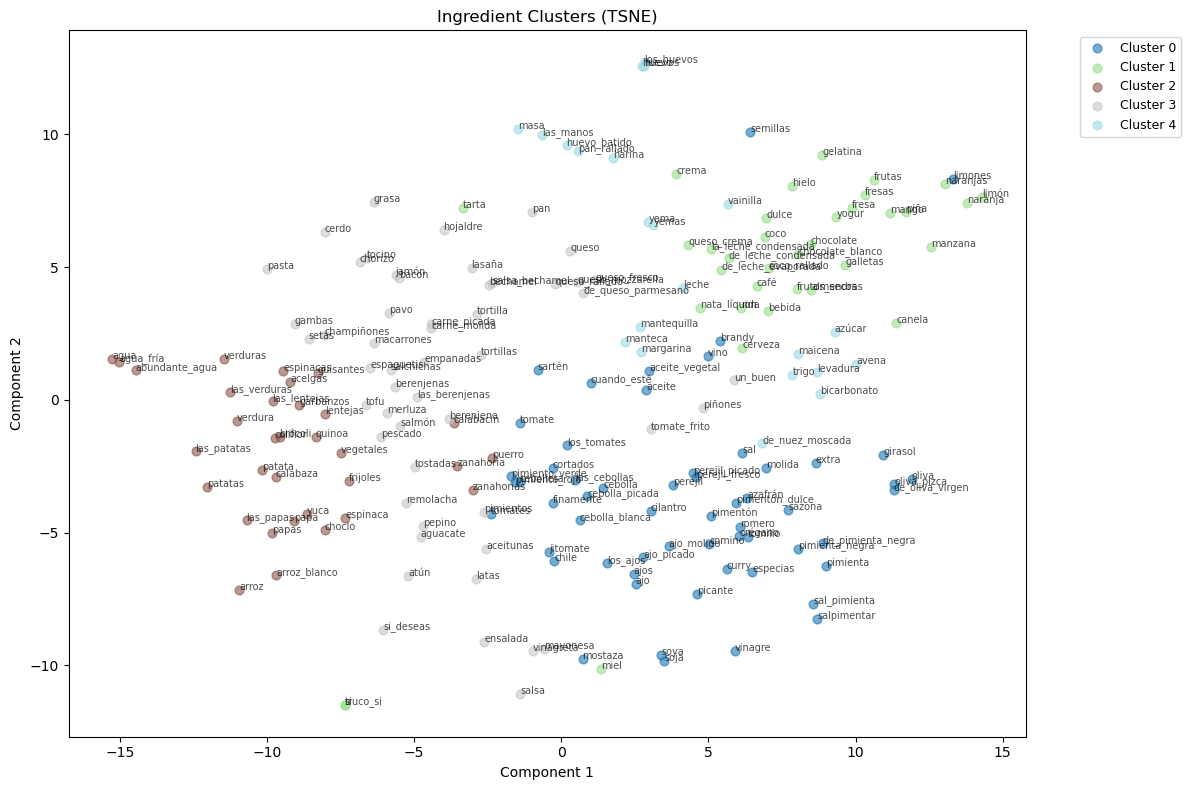

In [52]:
plot_clusters_2d(ingredientes_emb[:200], labels[:200], ingredientes_l[:200], method= 'tsne')

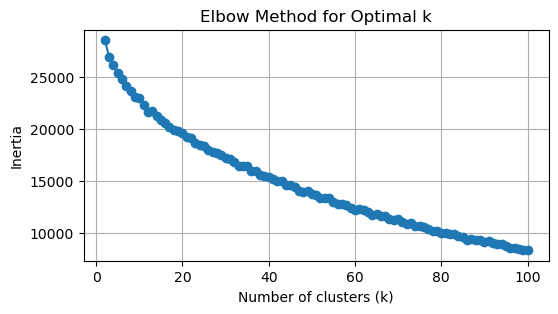

In [26]:
inertia = []
K = range(2, 101)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(ingredientes_emb)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,3))
plt.plot(K, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()

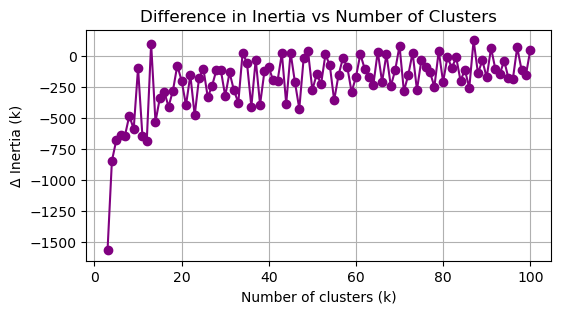

In [27]:
# Plot the difference in inertia (first derivative) to help identify the "elbow"
inertia_diff = np.diff(inertia)
plt.figure(figsize=(6,3))
plt.plot(K[1:], inertia_diff, 'o-', color='purple')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Δ Inertia (k)')  # Difference in inertia
plt.title('Difference in Inertia vs Number of Clusters')
plt.grid()
plt.show()

In [40]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_clusters_2d(embeddings, labels, words, method='pca', figsize=(12, 8), random_state=42):
    """
    Visualize clusters in 2D using PCA or t-SNE.
    
    Args:
        embeddings (np.ndarray): Embedding matrix (n_samples, n_features)
        labels (array-like): Cluster labels (n_samples,)
        words (list): List of words (n_samples,)
        method (str): 'pca' or 'tsne'
        figsize (tuple): Figure size
        random_state (int): Random state for reproducibility
    """
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=random_state, init='pca', learning_rate='auto')
        reduced = reducer.fit_transform(embeddings)
    else:
        reducer = PCA(n_components=2, random_state=random_state)
        reduced = reducer.fit_transform(embeddings)
    
    plt.figure(figsize=figsize)
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab20', len(unique_labels))
    
    for i, cluster in enumerate(unique_labels):
        idx = np.where(labels == cluster)[0]
        plt.scatter(reduced[idx, 0], reduced[idx, 1], s=40, color=colors(i), label=f'Cluster {cluster}', alpha=0.6)
        # Annotate each point with its word (small font)
        for j in idx:
            plt.text(reduced[j, 0], reduced[j, 1], words[j], fontsize=7, alpha=0.7)
    
    plt.title(f'Ingredient Clusters ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(markerscale=1, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.tight_layout()
    plt.show()